In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-vertical]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = True      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='[{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-09 02:04:00,481 - root - DEBUG - Keras backend is tensorflow.
2018-03-09 02:04:00,483 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-09 02:04:01,709 - root - DEBUG - Load Paired-annotation data
2018-03-09 02:04:01,710 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-09 02:04:01,711 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7fe9a41d5fc0>}
2018-03-09 02:04:22,411 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-09 02:04:22,412 - root - DEBUG - Number of samples for the current song: 272
2018-03-09 02:04:41,431 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-09 02:04:41,433 - root - DEBUG - Number of samples for the current song: 264
2018-03-09 02:04:48,605 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-09 02:04:48,606 - root - DEBUG - Number of samples for the current song: 100
2018-03-09 02:04:55,786 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-09 02:04:55,788 - root - DEBUG - Number of samples for the current son

In [6]:
p_train = .4
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-09 02:10:08,733 - root - DEBUG - Finish loading paired-annotation data
2018-03-09 02:10:08,735 - root - DEBUG - => There are 12 songs for training [41.41 percent]
2018-03-09 02:10:08,736 - root - DEBUG - => There are 8 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [7]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [8]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-09 02:10:09,075 - root - DEBUG - X1 shape: (3110, 1, 76, 121)
2018-03-09 02:10:09,076 - root - DEBUG - X2 shape: (3110, 1, 76, 121)
2018-03-09 02:10:09,077 - root - DEBUG - S shape: (3110, 1)
2018-03-09 02:10:09,078 - root - DEBUG - W shape: (3110, 1)
2018-03-09 02:10:09,079 - root - DEBUG - There are 2110 out of 3110 pairs that are similar [67.85 percent]
2018-03-09 02:10:09,598 - root - DEBUG - X1 shape: (3986, 1, 76, 121)
2018-03-09 02:10:09,599 - root - DEBUG - X2 shape: (3986, 1, 76, 121)
2018-03-09 02:10:09,600 - root - DEBUG - S shape: (3986, 1)
2018-03-09 02:10:09,601 - root - DEBUG - W shape: (3986, 1)
2018-03-09 02:10:09,602 - root - DEBUG - There are 2986 out of 3986 pairs that are similar [74.91 percent]


In [9]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [10]:
width = 76
height = 121
n_channel = 1

In [11]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Base model__

The first layer of the HashNet is a convolutional layer with full-height vertical filters, followed by a pooling layer that subsamples the time frames. We call these layers `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [12]:
f1, f2 = 64, 64

base_model = Sequential([
    Conv2D(f1, (1, height), activation='relu', use_bias=False, input_shape=(n_channel, width, height), name='conv_full_height'),
    MaxPooling2D(pool_size=(3, 1), name='pool_full_height')
#     Conv2D(f2, (width, 1), activation='relu', use_bias=False, name='conv_full_width')
])
logger.debug("Construct base model")

2018-03-09 02:10:09,678 - root - DEBUG - Construct base model


2018-03-09 02:10:09,795 - root - DEBUG - Save base_model architecture to base_model.png


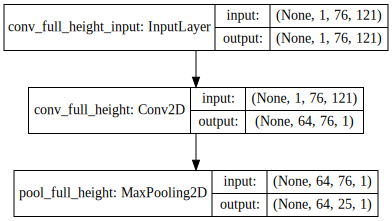

In [13]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [14]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [15]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.01         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-09 02:10:09,928 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.01


In [16]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [17]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [18]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [19]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-09 02:10:09,969 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [20]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [21]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-09 02:10:09,986 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-09 02:10:10,157 - root - DEBUG - Save model architecture to model.png


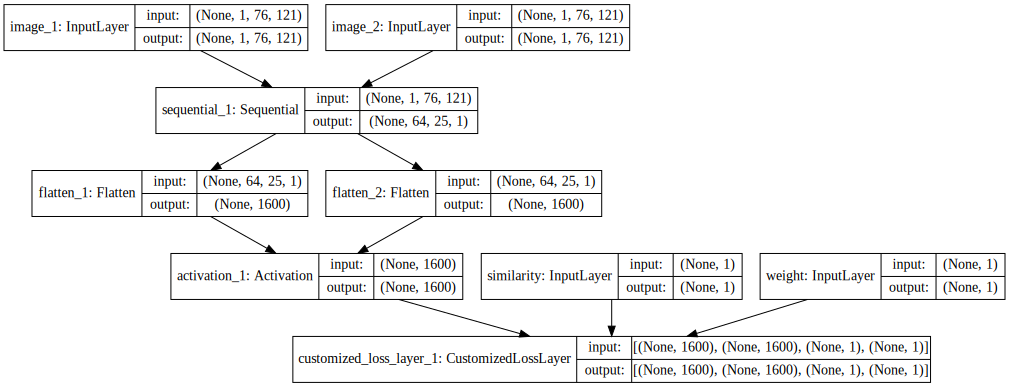

In [22]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [23]:
representation_model = Model(image_a, flatten_a)

In [24]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 500, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)
#     print(hist_sim)
#     print(hist_non_sim)
    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

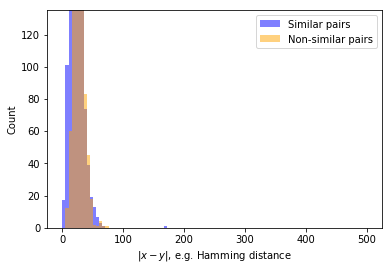

In [25]:
visualize(X1, X2, groundTruth, representation_model)

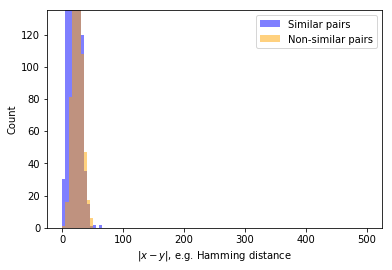

In [26]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [27]:
def visualizeFilters(idx_layer=0, nfilter=16):
    plt.figure(figsize=(10,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nfilter):
        filt = base_model.layers[idx_layer].get_weights()[0][:,:,0,i]
        plt.subplot((nfilter + 1) // 2, 2, i+1)
        plt.stem(filt.flatten())
        plt.xticks([])
        plt.yticks([])
        plt.title('Filter %d at Layer %d'%(i + 1, idx_layer + 1))
    plt.show()

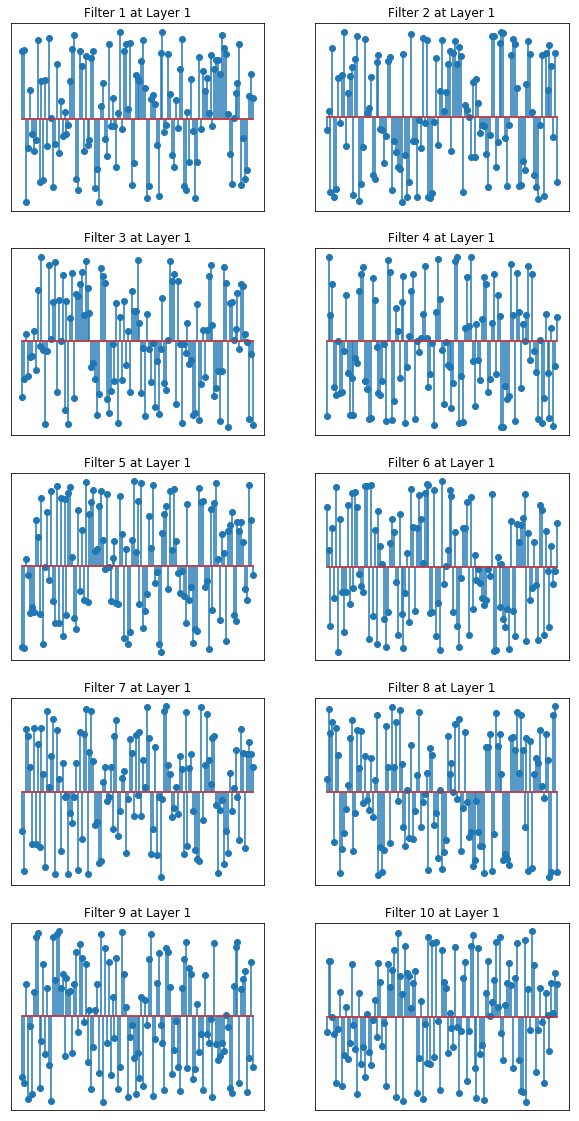

In [28]:
visualizeFilters(idx_layer=0, nfilter=10)

## Train a model

In [29]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-09 02:10:15,795 - root - DEBUG - Ready to train the model
2018-03-09 02:10:15,797 - root - DEBUG - X1 shape: (3110, 1, 76, 121)
2018-03-09 02:10:15,798 - root - DEBUG - X2 shape: (3110, 1, 76, 121)
2018-03-09 02:10:15,799 - root - DEBUG - S shape: (3110, 1)
2018-03-09 02:10:15,800 - root - DEBUG - W shape: (3110, 1)


In [30]:
number_of_iterations = 5
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 50
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-09 02:10:15,806 - root - DEBUG - [Training] number_of_iterations = 5
2018-03-09 02:10:15,808 - root - DEBUG - [Training] beta_factor = 5
2018-03-09 02:10:15,809 - root - DEBUG - [Training] number_of_epochs = 50


In [31]:
train_losses = []
test_losses = []

3986/3986 [==============================] - 1s 168us/step
2018-03-09 02:10:17,347 - root - DEBUG - [Before Training] Training Loss = 213.7461062683553, Testing Loss = 213.9780922306284
2018-03-09 02:10:17,348 - root - DEBUG - Iteration 1 (current beta = 1)
Epoch 1/50
3110/3110 [==============================] - 1s 313us/step - loss: 132.2322
Epoch 2/50
3110/3110 [==============================] - 1s 297us/step - loss: 50.9296
Epoch 3/50
3110/3110 [==============================] - 1s 318us/step - loss: 44.7657
Epoch 4/50
3110/3110 [==============================] - 1s 308us/step - loss: 44.7595
Epoch 5/50
3110/3110 [==============================] - 1s 315us/step - loss: 44.7347
Epoch 6/50
3110/3110 [==============================] - 1s 300us/step - loss: 44.7122
Epoch 7/50
3110/3110 [==============================] - 1s 296us/step - loss: 44.7176
Epoch 8/50
3110/3110 [==============================] - 1s 299us/step - loss: 44.7207
Epoch 9/50
3110/3110 [==============================]

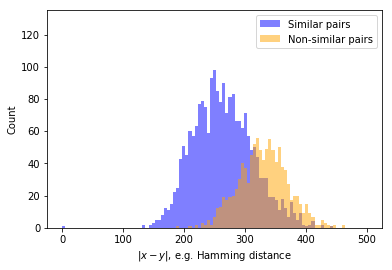

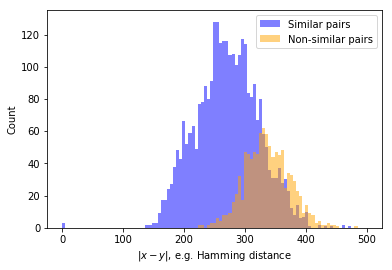

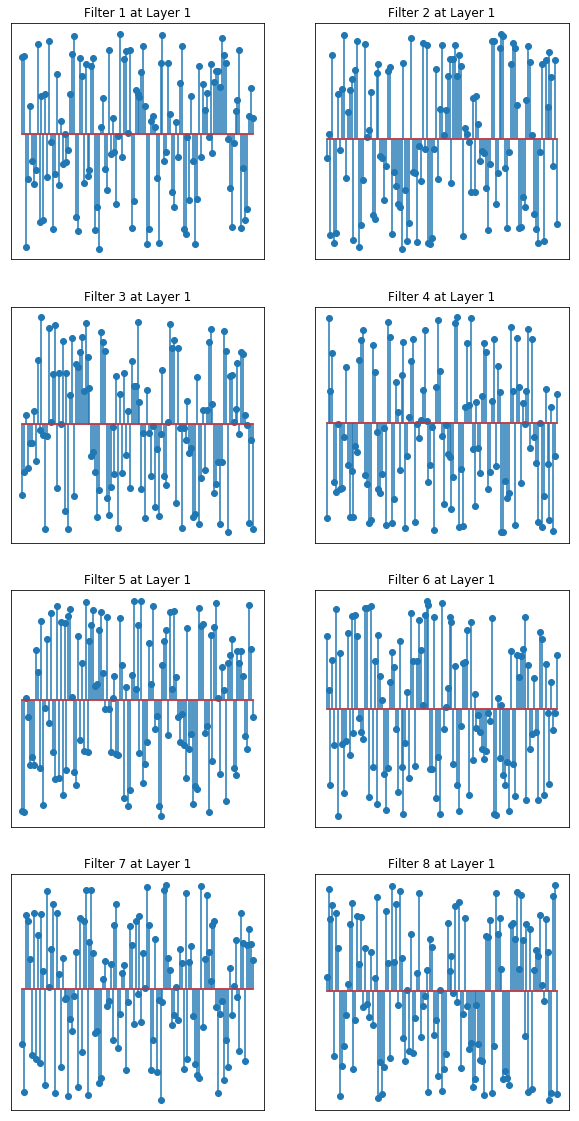

3986/3986 [==============================] - 1s 179us/step
2018-03-09 02:11:13,850 - root - DEBUG - [Iteration = 1] Training Loss = 43.8776481751077, Testing Loss = 43.973476350576625
2018-03-09 02:11:13,851 - root - DEBUG - Iteration 2 (current beta = 5)
Epoch 1/50
3110/3110 [==============================] - 1s 322us/step - loss: 43.9043
Epoch 2/50
3110/3110 [==============================] - 1s 328us/step - loss: 43.9470
Epoch 3/50
3110/3110 [==============================] - 1s 321us/step - loss: 43.9007
Epoch 4/50
3110/3110 [==============================] - 1s 321us/step - loss: 43.9107
Epoch 5/50
3110/3110 [==============================] - 1s 357us/step - loss: 43.8820
Epoch 6/50
3110/3110 [==============================] - 1s 319us/step - loss: 43.8998
Epoch 7/50
3110/3110 [==============================] - 1s 326us/step - loss: 43.8860
Epoch 8/50
3110/3110 [==============================] - 1s 321us/step - loss: 43.9163
Epoch 9/50
3110/3110 [==============================] - 

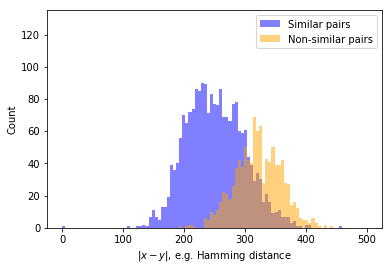

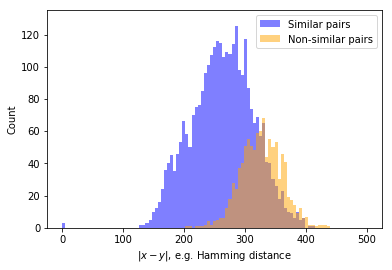

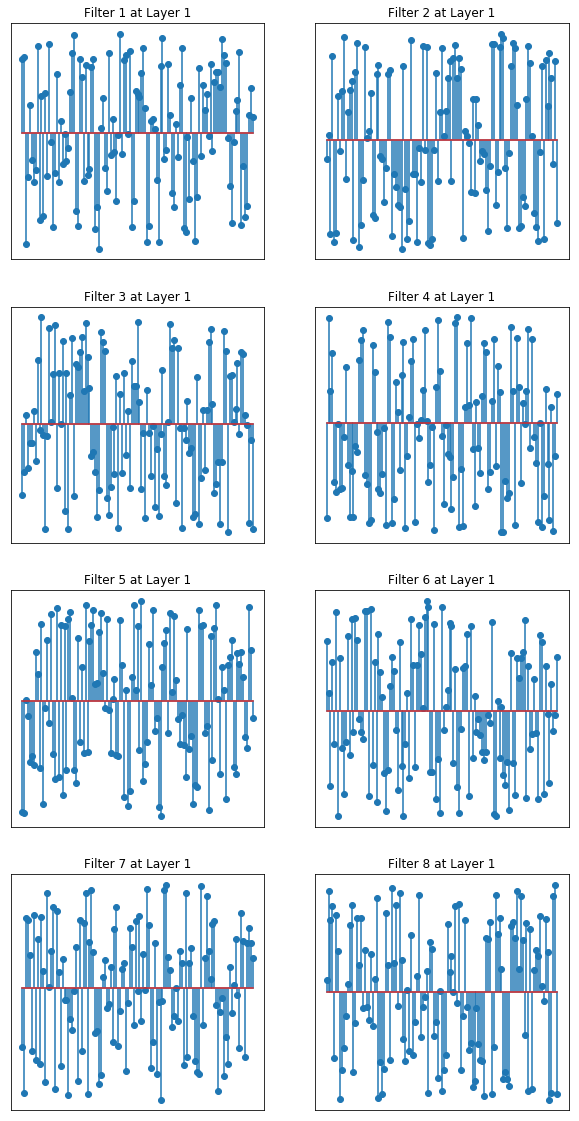

3986/3986 [==============================] - 1s 190us/step
2018-03-09 02:12:13,013 - root - DEBUG - [Iteration = 2] Training Loss = 43.8270875949185, Testing Loss = 43.96351144640396
2018-03-09 02:12:13,014 - root - DEBUG - Iteration 3 (current beta = 25)
Epoch 1/50
3110/3110 [==============================] - 1s 316us/step - loss: 43.8532
Epoch 2/50
3110/3110 [==============================] - 1s 333us/step - loss: 43.8144
Epoch 3/50
3110/3110 [==============================] - 1s 322us/step - loss: 43.8151
Epoch 4/50
3110/3110 [==============================] - 1s 331us/step - loss: 43.8427
Epoch 5/50
3110/3110 [==============================] - 1s 316us/step - loss: 43.8681
Epoch 6/50
3110/3110 [==============================] - 1s 330us/step - loss: 43.8083
Epoch 7/50
3110/3110 [==============================] - 1s 356us/step - loss: 43.8041
Epoch 8/50
3110/3110 [==============================] - 1s 315us/step - loss: 43.8177
Epoch 9/50
3110/3110 [==============================] - 

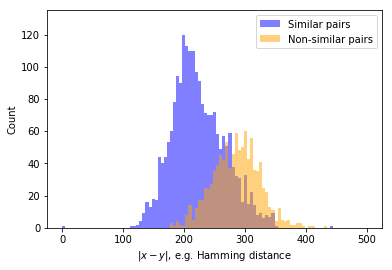

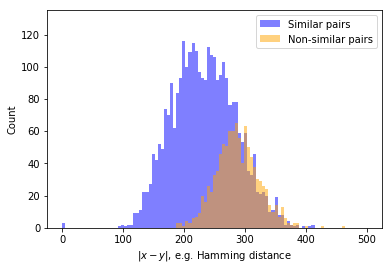

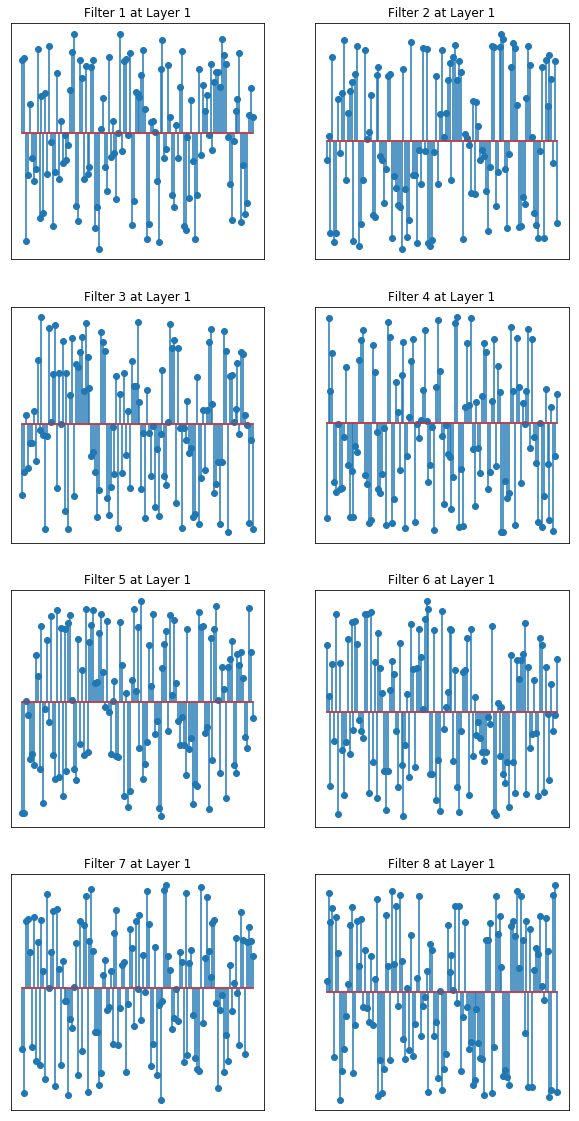

3986/3986 [==============================] - 1s 196us/step
2018-03-09 02:13:12,282 - root - DEBUG - [Iteration = 3] Training Loss = 43.63790223590814, Testing Loss = 43.8990006894247
2018-03-09 02:13:12,283 - root - DEBUG - Iteration 4 (current beta = 125)
Epoch 1/50
3110/3110 [==============================] - 1s 314us/step - loss: 43.7967
Epoch 2/50
3110/3110 [==============================] - 1s 329us/step - loss: 43.7246
Epoch 3/50
3110/3110 [==============================] - 1s 329us/step - loss: 43.6919
Epoch 4/50
3110/3110 [==============================] - 1s 478us/step - loss: 43.7423
Epoch 5/50
3110/3110 [==============================] - 1s 328us/step - loss: 43.7104
Epoch 6/50
3110/3110 [==============================] - 1s 322us/step - loss: 43.7482
Epoch 7/50
3110/3110 [==============================] - 1s 319us/step - loss: 43.7337
Epoch 8/50
3110/3110 [==============================] - 1s 345us/step - loss: 43.7324
Epoch 9/50
3110/3110 [==============================] -

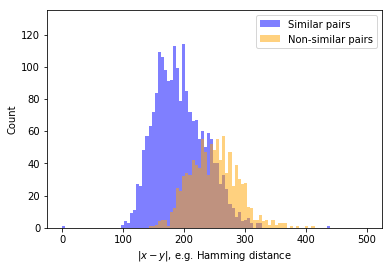

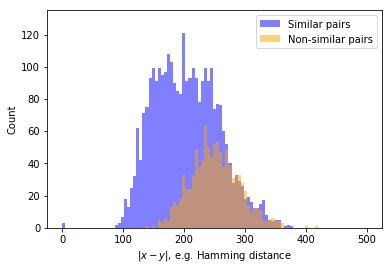

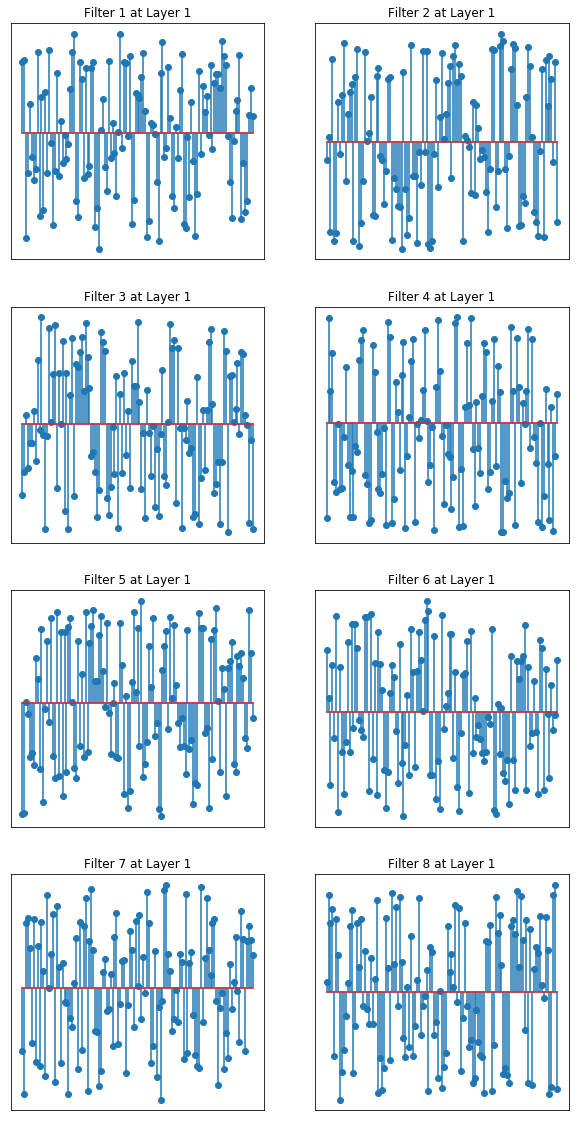

3986/3986 [==============================] - 1s 183us/step
2018-03-09 02:14:11,126 - root - DEBUG - [Iteration = 4] Training Loss = 43.55069544384334, Testing Loss = 43.902136102610356
2018-03-09 02:14:11,127 - root - DEBUG - Iteration 5 (current beta = 625)
Epoch 1/50
3110/3110 [==============================] - 1s 335us/step - loss: 43.6384
Epoch 2/50
3110/3110 [==============================] - 1s 348us/step - loss: 43.6455
Epoch 3/50
3110/3110 [==============================] - 1s 306us/step - loss: 43.6563
Epoch 4/50
3110/3110 [==============================] - 1s 342us/step - loss: 43.6162
Epoch 5/50
3110/3110 [==============================] - 1s 351us/step - loss: 43.6556
Epoch 6/50
3110/3110 [==============================] - 1s 308us/step - loss: 43.6608
Epoch 7/50
3110/3110 [==============================] - 1s 339us/step - loss: 43.6399
Epoch 8/50
3110/3110 [==============================] - 1s 317us/step - loss: 43.6475
Epoch 9/50
3110/3110 [==============================]

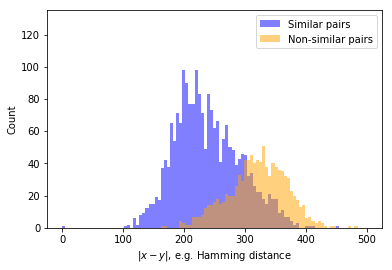

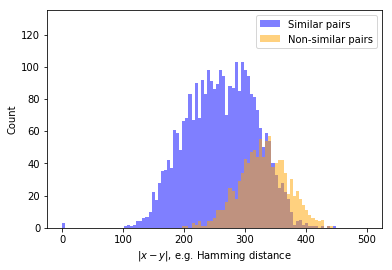

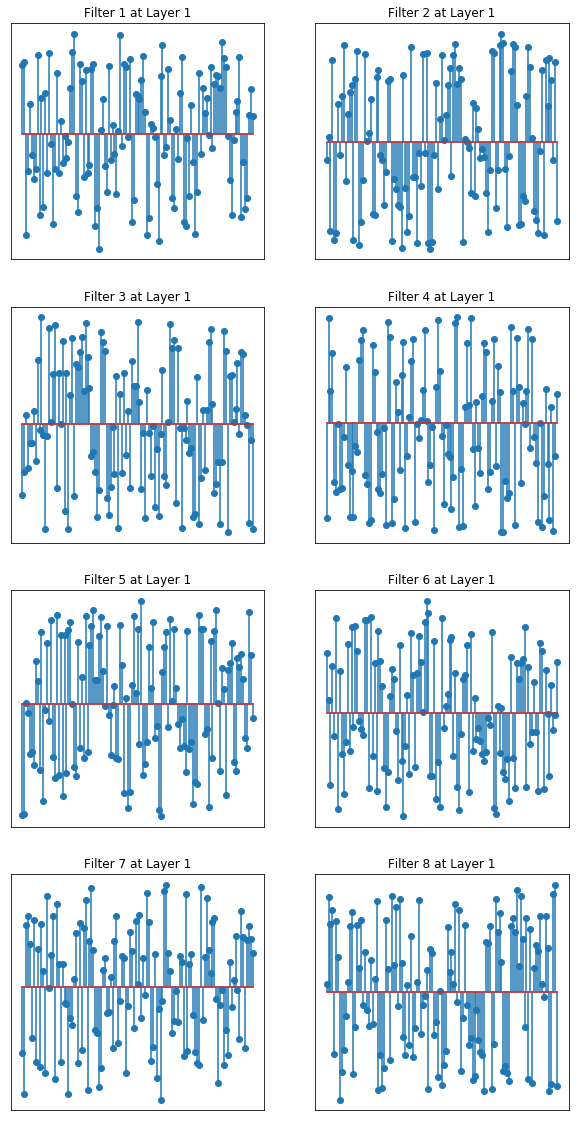

3986/3986 [==============================] - 1s 193us/step
2018-03-09 02:15:09,869 - root - DEBUG - [Iteration = 5] Training Loss = 43.49724738927516, Testing Loss = 43.90218291447741


In [32]:
train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
logger.debug("[Before Training] Training Loss = {:}, Testing Loss = {:}".format(train_loss, test_loss))

for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
    visualizeFilters(idx_layer=0, nfilter=8)
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

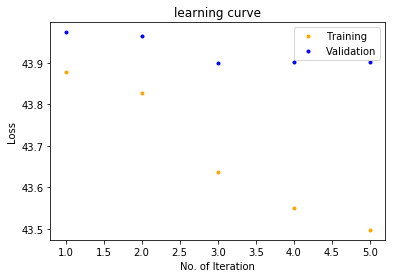

In [33]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

## Save Model

In [ ]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [ ]:
representation_model = Model(image_a, encoded_a)

In [ ]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

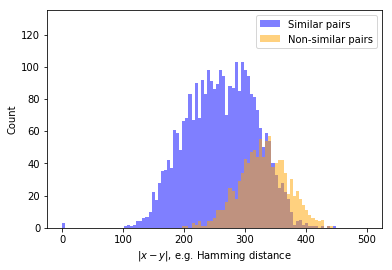

In [34]:
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 25, 1)    7744        image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1600)         0           sequential_1[1][0]               
__________

In [36]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_full_height (Conv2D)    (None, 64, 76, 1)         7744      
_________________________________________________________________
pool_full_height (MaxPooling (None, 64, 25, 1)         0         
Total params: 7,744
Trainable params: 7,744
Non-trainable params: 0
_________________________________________________________________
